# **Exploratory Data Analysis**

In [1]:
!pip install Roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="fHjvN0Omsz5XAduuX3xI")
project = rf.workspace("pothole-detection-fi0rt").project("pothole-semantic-segmentation")
version = project.version(1)
dataset = version.download("png-mask-semantic")
dataset_dir = dataset.location

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-Semantic-Segmentation-1 in png-mask-semantic:: 100%|██████████| 8540/8540 [00:03<00:00, 2513.22it/s]


In [1]:
import os
import shutil
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid')

In [2]:
image_dir = 'Pothole-Semantic-Segmentation-1/train'
output_dir = 'dataset'

#LOAD & MATCH FILES
all_files = os.listdir(image_dir)
images = sorted([f for f in all_files if f.endswith('.jpg')])
masks = sorted([f for f in all_files if f.endswith('.png') and '_mask' in f])

# Match images to corresponding masks
mask_dict = {}
for mask in masks:
    base = mask.replace('_mask.png', '')
    mask_dict[base] = mask

matched_pairs = []
for img in images:
    base = img.replace('.jpg', '')
    if base in mask_dict:
        matched_pairs.append((img, mask_dict[base]))

print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")
print(f"Total matched image-mask pairs: {len(matched_pairs)}")

Total images: 4268
Total masks: 4268
Total matched image-mask pairs: 4268


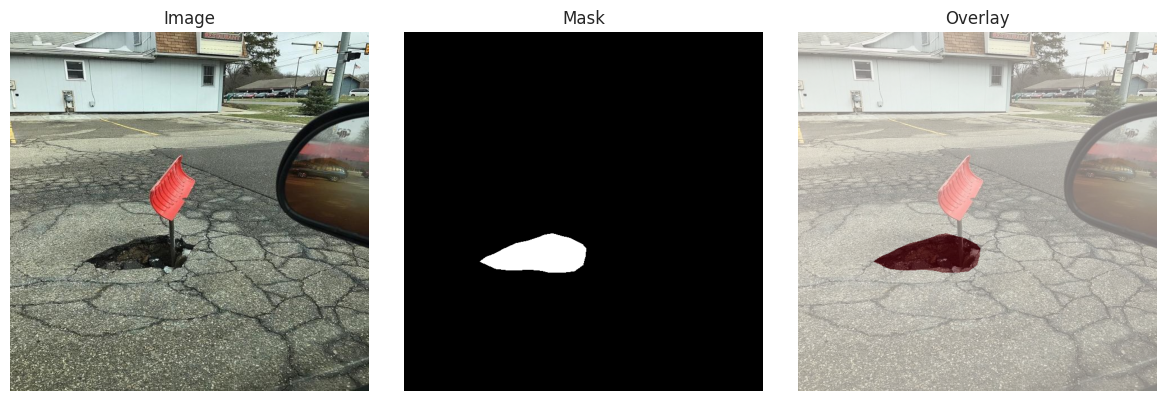

In [4]:
#RANDOM SAMPLE OVERLAY
def show_overlay(image_path, mask_path):
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path).convert('L'))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask, cmap='Reds', alpha=0.5)
    plt.title("Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

sample_img, sample_mask = random.choice(matched_pairs)
show_overlay(os.path.join(image_dir, sample_img), os.path.join(image_dir, sample_mask))


In [5]:
#IMAGE & MASK STATS
image_sizes = []
pothole_pixels = []
for img_name, mask_name in matched_pairs:
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(image_dir, mask_name)

    image = Image.open(img_path)
    image_sizes.append(image.size)

    mask = np.array(Image.open(mask_path).convert('L'))
    pothole_pixels.append(np.sum(mask > 0))

widths, heights = zip(*image_sizes)


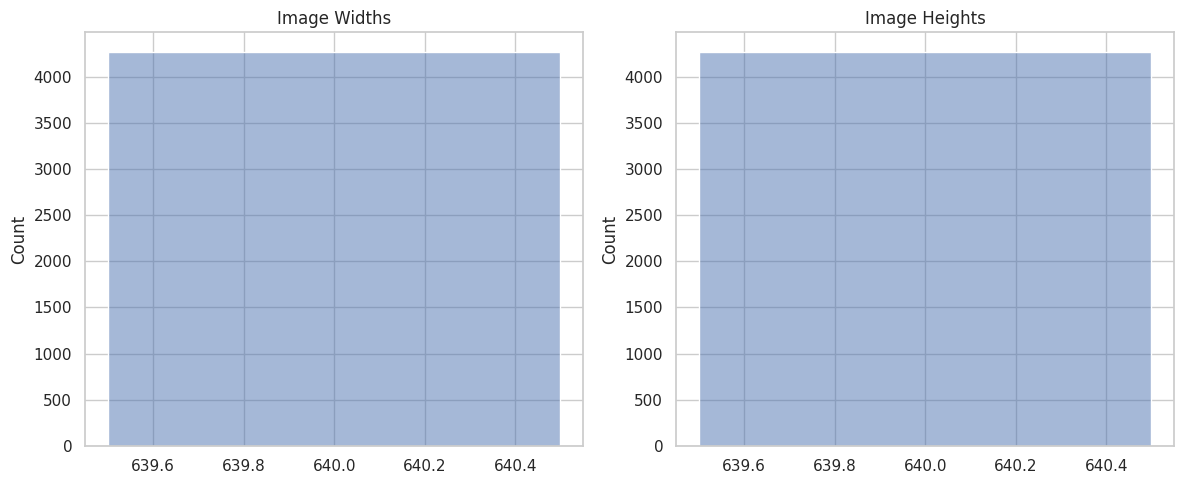

In [6]:
#VISUALIZE IMAGE SIZE DISTRIBUTION
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, kde=True)
plt.title("Image Widths")
plt.subplot(1, 2, 2)
sns.histplot(heights, kde=True)
plt.title("Image Heights")
plt.tight_layout()
plt.show()

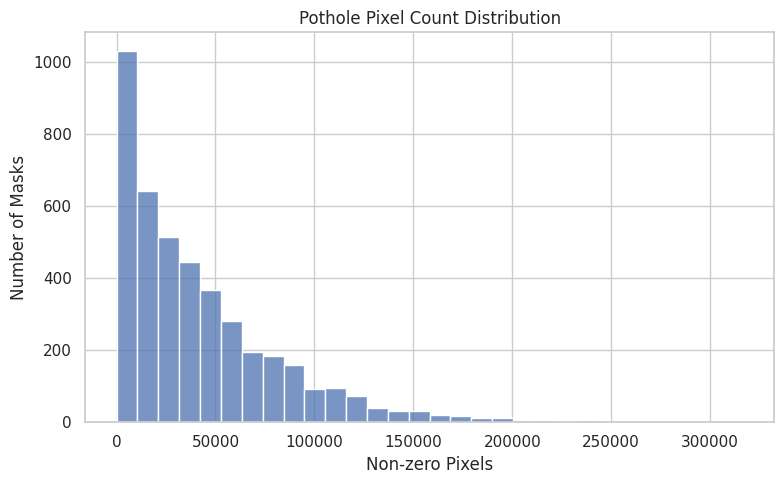

In [7]:
#POTHHOLE PIXEL COUNT DISTRIBUTION
#helps to understand how much pothole area is present in each image by counting the number of non-zero pixels in each mask.
plt.figure(figsize=(8, 5))
sns.histplot(pothole_pixels, bins=30)
plt.title("Pothole Pixel Count Distribution")
plt.xlabel("Non-zero Pixels")
plt.ylabel("Number of Masks")
plt.tight_layout()
plt.show()

#Interpretation: Left-skewed→ Most potholes are small

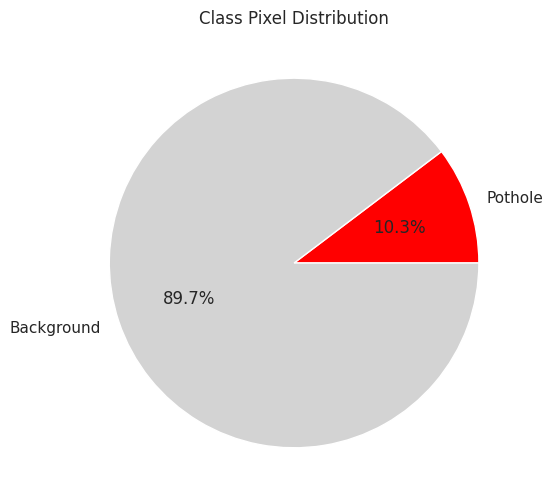

In [8]:
#POTHHOLE vs BACKGROUND CLASS DISTRIBUTION
total_pixels = [w * h for w, h in image_sizes]
bg_pixels = [t - p for t, p in zip(total_pixels, pothole_pixels)]

plt.figure(figsize=(6, 6))
plt.pie(
    [np.sum(pothole_pixels), np.sum(bg_pixels)],
    labels=["Pothole", "Background"],
    autopct='%1.1f%%',
    colors=["red", "lightgray"]
)
plt.title("Class Pixel Distribution")
plt.show()

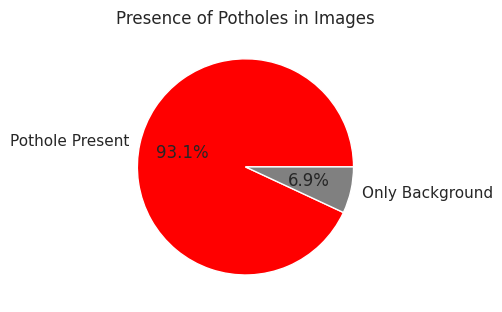

In [9]:
#Class Imbalance at the Mask Level
#Show how many masks have 0 potholes (only background) vs some pothole pixels

has_pothole = [p > 0 for p in pothole_pixels]

plt.figure(figsize=(5, 5))
plt.pie([sum(has_pothole), len(has_pothole) - sum(has_pothole)],
        labels=["Pothole Present", "Only Background"],
        autopct="%1.1f%%",
        colors=["red", "gray"])
plt.title("Presence of Potholes in Images")
plt.tight_layout()
plt.show()


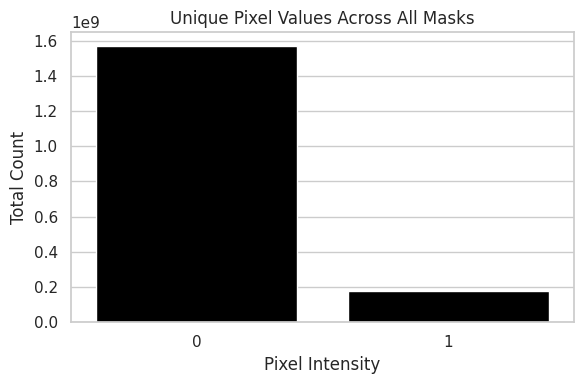

In [11]:
#Grayscale Mask Intensity Distribution- checks binary masks value (only 0 and 255)

from collections import Counter
pixel_counter = Counter()

for _, mask_name in matched_pairs:
    mask_path = os.path.join(image_dir, mask_name)
    mask = np.array(Image.open(mask_path).convert('L'))
    uniques, counts = np.unique(mask, return_counts=True)
    pixel_counter.update(dict(zip(uniques, counts)))

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=list(pixel_counter.keys()), y=list(pixel_counter.values()), color='black')
plt.title("Unique Pixel Values Across All Masks")
plt.xlabel("Pixel Intensity")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()


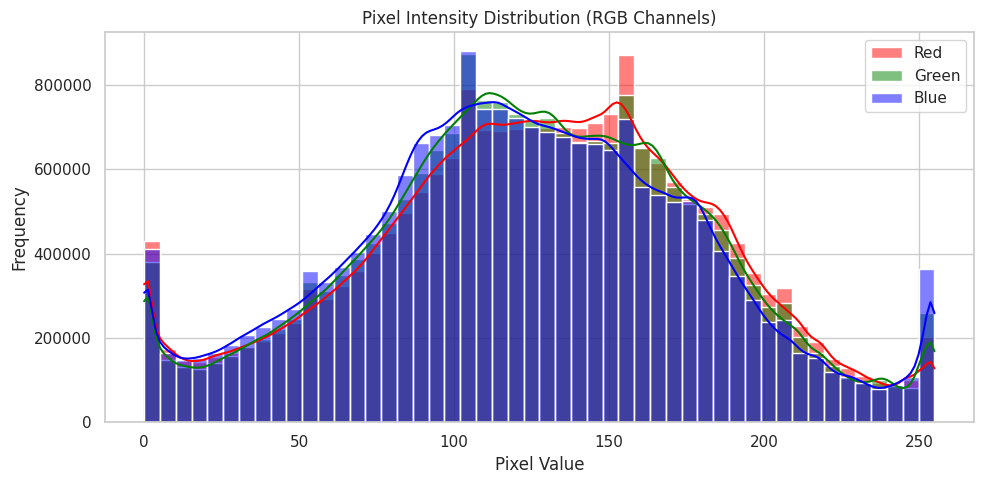

In [18]:
# Intensity analysis (e.g., 50 samples) that Helps in Calculating MEAN STD used during Transformation and Augumentation

sampled_images = random.sample(images, min(50, len(images)))
r_vals, g_vals, b_vals = [], [], []

for img_name in sampled_images:
    img_path = os.path.join(image_dir, img_name)
    image = np.array(Image.open(img_path).convert('RGB'))  # Ensure RGB

    r_vals.extend(image[:, :, 0].flatten())
    g_vals.extend(image[:, :, 1].flatten())
    b_vals.extend(image[:, :, 2].flatten())

plt.figure(figsize=(10, 5))
sns.histplot(r_vals, color='red', label='Red', bins=50, kde=True)
sns.histplot(g_vals, color='green', label='Green', bins=50, kde=True)
sns.histplot(b_vals, color='blue', label='Blue', bins=50, kde=True)
plt.title("Pixel Intensity Distribution (RGB Channels)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
#Help in Calculating MEAN STD used during Transformation and Augumentation
import numpy as np
from PIL import Image
import os
import random

r_vals, g_vals, b_vals = [], [], []
sampled_images = random.sample(images, min(50, len(images)))

for img_name in sampled_images:
    img_path = os.path.join(image_dir, img_name)
    image = np.array(Image.open(img_path).convert('RGB')) / 255.0  # Normalize to [0,1]
    r_vals.extend(image[:, :, 0].flatten())
    g_vals.extend(image[:, :, 1].flatten())
    b_vals.extend(image[:, :, 2].flatten())

# Compute mean and std per channel
mean = [np.mean(r_vals), np.mean(g_vals), np.mean(b_vals)]
std = [np.std(r_vals), np.std(g_vals), np.std(b_vals)]

print("Channel-wise Mean:", mean)
print("Channel-wise Std Dev:", std)


Channel-wise Mean: [np.float64(0.4998810830269597), np.float64(0.48653796702665425), np.float64(0.471917316559437)]
Channel-wise Std Dev: [np.float64(0.21051710513052657), np.float64(0.2076896831788104), np.float64(0.2159267077070667)]


In [15]:
# TRAIN/VAL/TEST SPLIT after verifying everything
train_val_pairs, test_pairs = train_test_split(matched_pairs, test_size=0.1, random_state=42)
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.1111, random_state=42)

print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

#COPY TO STRUCTURED FOLDERS
def create_split(split_name, pairs):
    os.makedirs(f'{output_dir}/{split_name}/images', exist_ok=True)
    os.makedirs(f'{output_dir}/{split_name}/masks', exist_ok=True)
    for img_name, mask_name in pairs:
        shutil.copy(os.path.join(image_dir, img_name), f'{output_dir}/{split_name}/images/{img_name}')
        shutil.copy(os.path.join(image_dir, mask_name), f'{output_dir}/{split_name}/masks/{mask_name}')

create_split('train', train_pairs)
create_split('val', val_pairs)
create_split('test', test_pairs)



Train pairs: 3414
Validation pairs: 427
Test pairs: 427


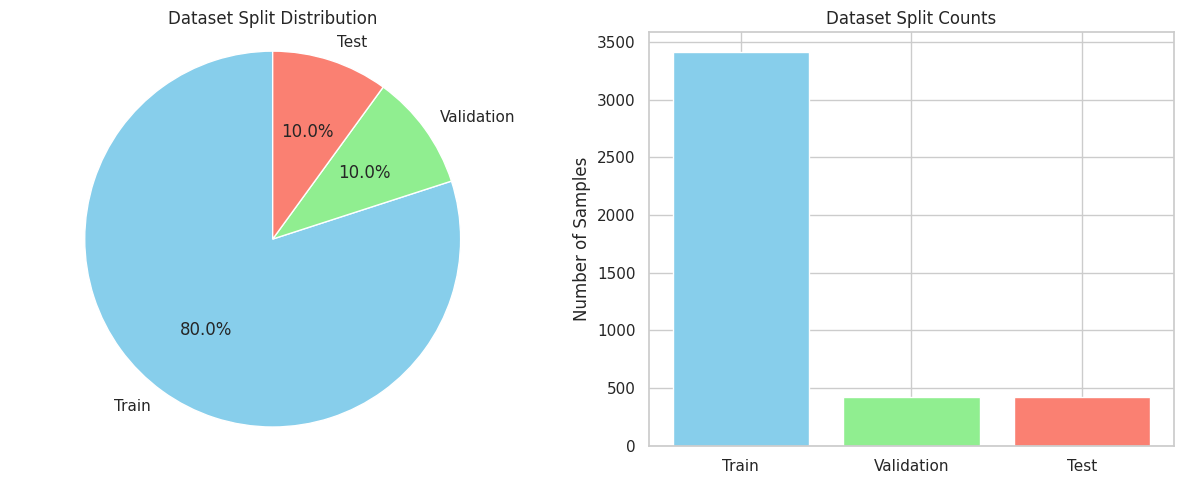

In [16]:
#SPLIT DISTRIBUTION PLOTS
split_counts = {
    'Train': len(train_pairs),
    'Validation': len(val_pairs),
    'Test': len(test_pairs)
}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie Chart
axes[0].pie(split_counts.values(), labels=split_counts.keys(), autopct='%1.1f%%',
            startangle=90, colors=['skyblue', 'lightgreen', 'salmon'])
axes[0].set_title("Dataset Split Distribution")
axes[0].axis('equal')

# Bar Chart
axes[1].bar(split_counts.keys(), split_counts.values(), color=['skyblue', 'lightgreen', 'salmon'])
axes[1].set_title("Dataset Split Counts")
axes[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()
